In [1]:
"""
@Josh Boquiren
Ver. I
OTIS Lab MUSC
9.27.2022

==========

Purpose:
Loop through folders starting from a parent directory. Handles 3-Dimensional NPY arrays. Calculates the averages
across the Z-axis (typically frames across time), then averages the NPYs together, accounting for NaN values, and plots.

Notes:
* Data organization is key to use this! If structure does not follow particular order, it may not process properly
    * Structure should look like:
    -> parent folder
        -> sub folders for each condition
            -> NPY files
    * Should try to reformat requirements to match Jackie's folder organization:
    -> project parent folder
        -> sub-folders for conditions
            -> sub-folders for FOVs
                -> NPY files
* in order to get the comparison plot, you have to custom code that per project I think
* Utilize np.squeeze and enumerate functions from Ian's code

"""

"\n@Josh Boquiren\nVer. I\nOTIS Lab MUSC\n9.27.2022\n\n==========\n\nPurpose:\nLoop through folders starting from a parent directory. Handles 3-Dimensional NPY arrays. Calculates the averages\nacross the Z-axis (typically frames across time), then averages the NPYs together, accounting for NaN values, and plots.\n\nNotes:\n* Data organization is key to use this! If structure does not follow particular order, it may not process properly\n    * Structure should look like:\n    -> parent folder\n        -> sub folders for each condition\n            -> NPY files\n    * Should try to reformat requirements to match Jackie's folder organization:\n    -> project parent folder\n        -> sub-folders for conditions\n            -> sub-folders for FOVs\n                -> NPY files\n* in order to get the comparison plot, you have to custom code that per project I think\n* Utilize np.squeeze and enumerate functions from Ian's code\n\n"

In [2]:
#Import Libraries

import os #functions on the system
import numpy as np #functions on arrays
import pandas as pd #functions on DataFrames
import matplotlib.pyplot as plt #plot functions
import seaborn as sns #more plot functions
from scipy.stats import sem #statistic functions
import random #random generator

In [3]:
#Functions

#simple function to calculate the average of a list
def avg(arr): #accepts an array as a parameter
    length = len(arr)
    sigma = 0
    for i in arr:
        sigma = sigma + i
    avg = sigma/length
    return(avg) #returns the average...duh

#function to calculate the averages of frames per cell across time
def NPY_frame_avg(NPY_folder): #accepts a folder of ROIs as a parameter
    avg_frames = []
    for fov_file in os.listdir(NPY_folder): #iterates through each file in the folder
        if fov_file.endswith(".npy"):
            fov = np.load(os.path.join(NPY_folder, fov_file)) #produces 3D array from NPY file
            for cell_arr in fov:
                cell_df = pd.DataFrame(cell_arr) #convert to DataFrame for easier handling
                means_arr = [] #array for storing frame means
                for frame in cell_df:
                    frame_mean = cell_df[frame].mean() #.mean() automatically assigns NaN in DataFrames
                    means_arr.append(frame_mean)
                avg_frames.append(means_arr)
    return(avg_frames) #returns an array

#function to calculate the baseline (does not subtract baseline)
def get_baseline(arr, baseline_start_frame, baseline_end_frame): #accpets an array, and a baseline starting and ending frame
    df = pd.DataFrame(arr)
    avg_frames = []
    for i in df[baseline_start_frame:baseline_end_frame]: #only iterates through specified frames
        avg_frames.append(df[i].mean())
    return(avg(avg_frames)) #returns a float average
    

In [4]:
#Loop through folders

# C:\Users\jboqu\OneDrive\Desktop\OTIS_Lab\Projects\PvtChrimson-AstroGC

parent_dir = input(">>> Enter parent directory file path: ")
baseline_start = int(input(">>> Enter beginning frame interger for baseline (MUST BE AN INTERGER): "))
baseline_end = int(input(">>> Enter ending frame interger for baseline (MUST BE AN INTERGER): "))
cutoff = float(input(">>> Enter an interger for a cut-off value (use for light artifacts - recommend 1): "))
print("\nNumber of items to iterate through: ", len(os.listdir(parent_dir)), "\n")

NPY_DICT_ARR = []
for folder in os.listdir(parent_dir):
    if str(folder).__contains__("."): #condition to avoid processing non-NPY file containing folders
        print("---> Processing:", folder, "\n!!!ERROR!!! ", folder, " is not a directory.")
    else:
        try: #another exception handler
            folder_path = os.path.join(parent_dir, folder)
            print("---> Processing:", folder)
            averaged_frames = NPY_frame_avg(folder_path) #calls function to average frames
            baseline = get_baseline(averaged_frames, baseline_start, baseline_end) #calls function to create baseline
            for frame_set in averaged_frames:
                new_avg_arr = [] #just a place to store the new values
                for frame in frame_set:
                    new_val = frame-baseline #subtracting baseline from the original averaged frame
                    if new_val < cutoff: #if the new value is below the cutoff, accounting for light artifacts
                        new_avg_arr.append(new_val)
            NPY_DICT_ARR.append({"Folder": folder, "Array": new_avg_arr}) #creates a dictionary for reference
            print("Finished!")
        except Exception as e:
            print("AYOOO THERE'S SOMETHING WRONG HERE...", e) #cause why not lol

>>> Enter parent directory file path: C:\Users\jboqu\OneDrive\Desktop\OTIS_Lab\Projects\PvtChrimson-AstroGC
>>> Enter beginning frame interger for baseline (MUST BE AN INTERGER): 0
>>> Enter ending frame interger for baseline (MUST BE AN INTERGER): 400
>>> Enter an interger for a cut-off value (use for light artifacts - recommend 1): 1

Number of items to iterate through:  2 

---> Processing: 0Hz
AYOOO THERE'S SOMETHING WRONG HERE... division by zero
---> Processing: 20Hz
AYOOO THERE'S SOMETHING WRONG HERE... division by zero


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


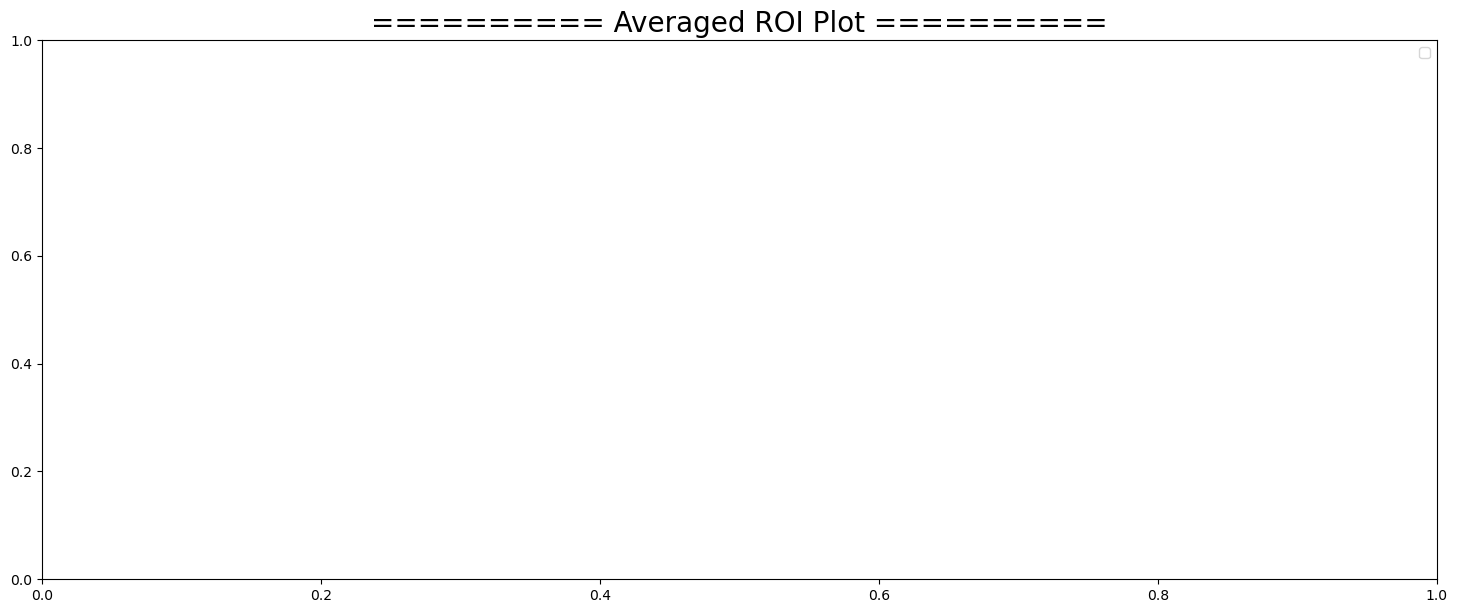

In [5]:
#Make plots

try:
    colors = ["red", "black", "blue", "magenta", "green"]
    plt.figure(figsize=(18,7))
    for ROI_set in NPY_DICT_ARR:
        sns.set_style("darkgrid")
        plt.plot(ROI_set["Array"], color=colors[random.randint(0,3)], lw=.7, label=ROI_set["Folder"])
    plt.legend()
    plt.title("========== Averaged ROI Plot ==========", fontsize=20)
    plt.show()
except Exception as e:
    print(e)